# **Generic** 

In [937]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [938]:
def crop_barcode3(img):
    # Find contours in the binary image
    contours, _ = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour corresponds to the barcode
    largest_contour = max(contours, key=cv.contourArea)
    largest_contour_area = cv.contourArea(largest_contour)

    # Initialize variables to store the leftmost and rightmost contours
    leftmost_contour = None
    rightmost_contour = None
    x_min = float('inf')
    x_max = float('-inf')

    # Find the leftmost and rightmost contours
    for contour in contours:
        contour_area = cv.contourArea(contour)
        if contour_area >= 0.05 * largest_contour_area:  # Check if the contour area is significant
            x, _, w, _ = cv.boundingRect(contour)
            if x < x_min:
                x_min = x
                leftmost_contour = contour
            if x > x_max:  # Use x to get the far-right edge of the contour
                x_max = x
                rightmost_contour = contour

    x_min, _, _, _ = cv.boundingRect(leftmost_contour)
    x_max, _, w, _ = cv.boundingRect(rightmost_contour)

    # Get the vertical limits from the largest contour
    _, y, _, h = cv.boundingRect(largest_contour)

    # Crop the image so that only the barcode is visible
    cropped_img = img[y:y + h, x_min:x_max+w]

    # Draw all contours in red
    contour_img = cv.cvtColor(cv.bitwise_not(img), cv.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing
    cv.drawContours(contour_img, contours, -1, (255, 0, 0), 4)  # Draw all contours in red

    return cropped_img, contour_img

def display_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    # Draw border around the image
    #plt.gca().add_patch(plt.Rectangle((0, 0), img.shape[1], img.shape[0], fill=None, edgecolor='blue', linewidth=2))
    plt.axis('off')
    plt.show()

**Read Image**

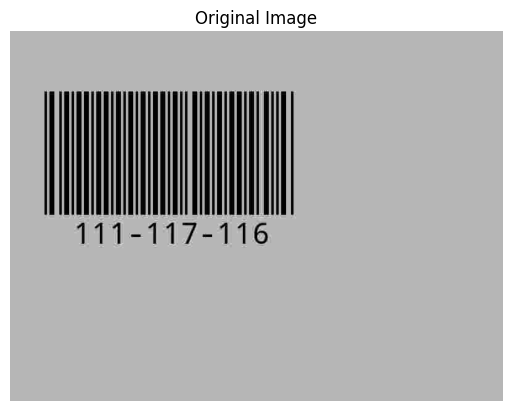

In [939]:
# Read the image
# img = cv.imread('Samples/Test Cases/01 - lol easy.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/02 - still easy.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/04 - fen el nadara.jpg', cv.IMREAD_GRAYSCALE)
img = cv.imread('Samples/Test Cases/05 - meen taffa el nour!!!.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/07 - mal7 w felfel.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/08 - compresso espresso.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/09 - e3del el sora ya3ammm.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/10 - wen el kontraastttt.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.imread('Samples/Test Cases/11 - bayza 5ales di bsara7a.jpg', cv.IMREAD_GRAYSCALE)

display_image(img, 'Original Image')


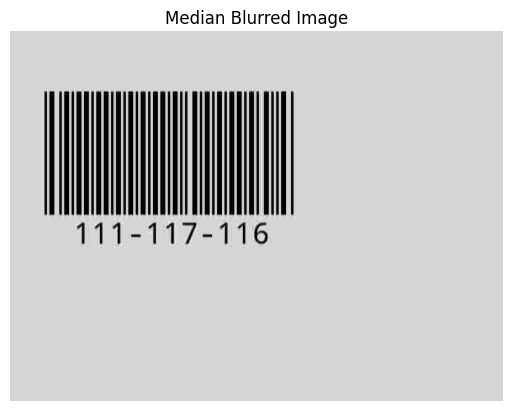

In [940]:
# Apply Median Blur
kernel = np.ones((3,1),np.float32)/3
median_blurred_img = cv.filter2D(img,-1,kernel)
display_image(median_blurred_img, 'Median Blurred Image')

**Adjust Contrast**

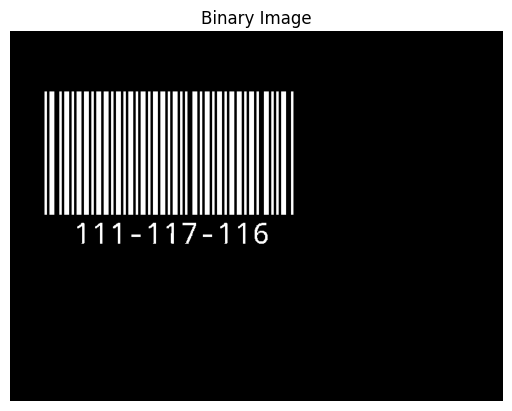

In [941]:
"""
def adjust_contrast(img):
    # Calculate the histogram of the image
    hist = cv.calcHist([img], [0], None, [256], [0, 256])
    
    # Calculate the cumulative distribution function (CDF)
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    
    # Determine if the image is too dark or too bright
    if cdf[0] > 0.5 * cdf[-1]:
        # Image is too dark, increase brightness
        img = cv.convertScaleAbs(img, alpha=1.5, beta=50)
    elif cdf[-1] - cdf[-2] > 0.5 * cdf[-1]:
        # Image is too bright, decrease brightness
        img = cv.convertScaleAbs(img, alpha=0.5, beta=-50)
    
    # Apply histogram equalization to improve contrast with controlled power
    clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    # Apply histogram equalization to improve contrast
    # img = cv.equalizeHist(img)
    
    return img

# Adjust the contrast of the image
adjusted_img = adjust_contrast(median_blurred_img)
# Display the adjusted image
display_image(adjusted_img, 'Adjusted Image')
"""

_, binary_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
display_image(binary_img, 'Binary Image')

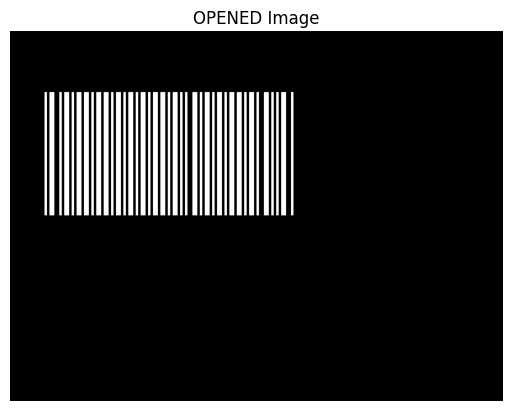

In [942]:
vertical_kernel = np.ones((60, 1), np.uint8)
opened_img = cv.morphologyEx(binary_img, cv.MORPH_OPEN, vertical_kernel, iterations=1)
display_image(opened_img, 'OPENED Image')


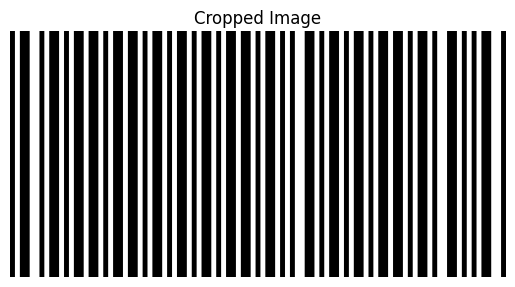

In [943]:
cropped_img, contour_img = crop_barcode3(opened_img)
display_image(cv.bitwise_not(cropped_img), 'Cropped Image')

In [944]:
# 0 means narrow, 1 means wide
NARROW = "0"
WIDE = "1"
code11_widths = {
    "00110": "Stop/Start",
    "10001": "1",
    "01001": "2",
    "11000": "3",
    "00101": "4",
    "10100": "5",
    "01100": "6",
    "00011": "7",
    "10010": "8",
    "10000": "9",
    "00001": "0",
    "00100": "-",
}

# Threshold the cropped image
mean = cropped_img.mean(axis=0)  # Column-wise mean
mean = np.where(mean <= 127, 1, 0)  # Black or White

print("Mean Array:", mean)  # Check the binary output

# Convert to string of pixels in order to loop over it
pixels = ''.join(mean.astype(np.uint8).astype(str))

# Need to figure out how many pixels represent a narrow bar
narrow_bar_size = 0
for pixel in pixels:
    if pixel == "1":
        narrow_bar_size += 1
    else:
        break

wide_bar_size = narrow_bar_size * 2

digits = []
pixel_index = 0
current_digit_widths = ""
skip_next = False

while pixel_index < len(pixels):

    if skip_next:
        pixel_index += narrow_bar_size
        skip_next = False
        continue

    count = 1
    try:
        while pixels[pixel_index] == pixels[pixel_index + 1]:
            count += 1
            pixel_index += 1
    except:
        pass
    pixel_index += 1

    # Determine if the bar width is narrow or wide
    if 3 <= count <= 5:
        current_digit_widths += NARROW
    elif 7 <= count <= 9:
        current_digit_widths += WIDE

    if current_digit_widths in code11_widths:
        digits.append(code11_widths[current_digit_widths])
        current_digit_widths = ""
        skip_next = True  # Next iteration will be a separator, so skip it

print(digits)

Mean Array: [0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1
 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1
 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1
 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0
 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0
 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0
 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0]
['Stop/Start']
